In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset

In [95]:
#!pip install scikit-learn

In [96]:
# Load the dataset (LibSVM format)
data_path = '/content/drive/MyDrive/Colab Notebooks/diabetes_scale.txt'
X, y = load_svmlight_file(data_path)
X = X.toarray()

# Convert labels from {-1, 1} to {0, 1} format for binary classification
y = np.where(y == -1, 0, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [97]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add an extra dimension for binary output
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [98]:
class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_size):
        super(SingleLayerPerceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    # Apply the linear transformation and sigmoid activation
    def forward(self, x):
        x = torch.sigmoid(self.fc(x))
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of features
model = SingleLayerPerceptron(input_size)


In [99]:
# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training parameters
epochs = 100

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.6757
Epoch [20/100], Loss: 0.6676
Epoch [30/100], Loss: 0.6600
Epoch [40/100], Loss: 0.6531
Epoch [50/100], Loss: 0.6467
Epoch [60/100], Loss: 0.6408
Epoch [70/100], Loss: 0.6355
Epoch [80/100], Loss: 0.6306
Epoch [90/100], Loss: 0.6262
Epoch [100/100], Loss: 0.6221


Test Accuracy: 62.34% 



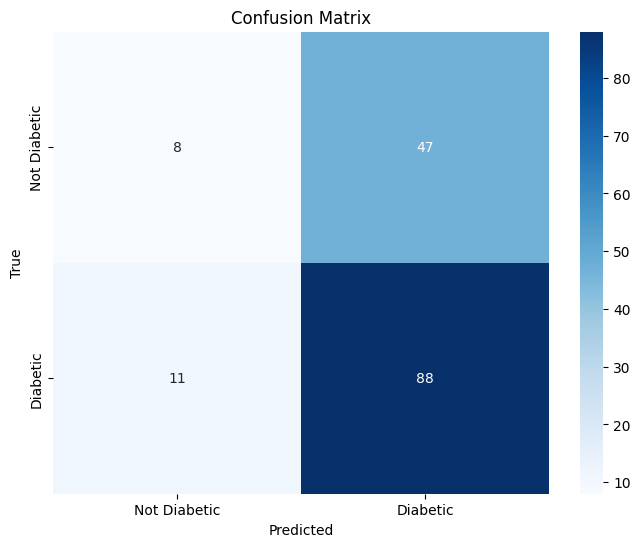


Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.15      0.22        55
           1       0.65      0.89      0.75        99

    accuracy                           0.62       154
   macro avg       0.54      0.52      0.48       154
weighted avg       0.57      0.62      0.56       154



In [100]:
# Model Evaluation
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_predictions = test_predictions.round()

    # accuracy
    accuracy = (test_predictions.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}% \n')

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Diabetic', 'Diabetic'],
                yticklabels=['Not Diabetic', 'Diabetic'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # classification report
    test_predictions_np = test_predictions.numpy()  # Convert predictions to NumPy array
    print("\nClassification Report:\n", classification_report(y_test, test_predictions_np))


**Improve performance By mini-batch training**

In [101]:

# Create TensorDataset and DataLoader for mini-batch training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training loop with mini-batches
for epoch in range(epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.4912
Epoch [20/100], Loss: 0.8552
Epoch [30/100], Loss: 0.6560
Epoch [40/100], Loss: 0.4720
Epoch [50/100], Loss: 0.4581
Epoch [60/100], Loss: 0.3617
Epoch [70/100], Loss: 0.4974
Epoch [80/100], Loss: 0.4673
Epoch [90/100], Loss: 0.8943
Epoch [100/100], Loss: 0.2095


Test Accuracy: 74.68% 



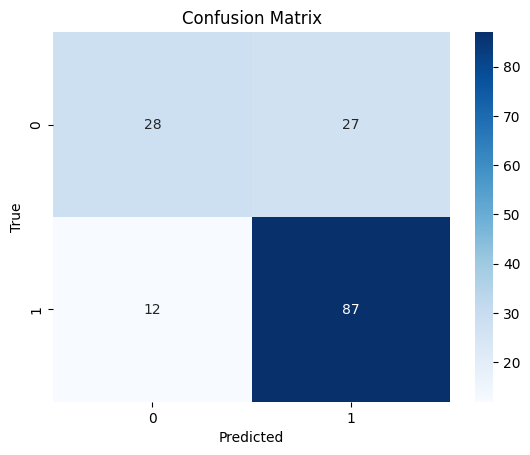

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.51      0.59        55
           1       0.76      0.88      0.82        99

    accuracy                           0.75       154
   macro avg       0.73      0.69      0.70       154
weighted avg       0.74      0.75      0.74       154



In [102]:

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_predictions = test_predictions.round()

    # accuracy
    accuracy = (test_predictions.eq(y_test_tensor).sum() / y_test_tensor.shape[0]).item()
    print(f'Test Accuracy: {accuracy * 100:.2f}% \n')

    # Confusion Matrix
    cm = confusion_matrix(y_test, test_predictions.numpy())
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification Report
    report = classification_report(y_test, test_predictions.numpy())
    print("Classification Report:\n", report)
